# Estimating Conditional Average Treatment Effect (CATE) using Meta-Learners
# Author: [Lalita Awasthi]
# Date: [8/3/2024]

##  Introduction
In this notebook, we will explore the estimation of Conditional Average Treatment Effect (CATE) using various meta-learners.
CATE is a crucial metric in causal inference, representing the expected treatment effect given a set of covariates.
This study focuses on educational interventions, leveraging observational data from the National Study of Learning Mindsets.
We will implement and compare four meta-learners: T-Learner, S-Learner, X-Learner, and R-Learner.

Meta-learners are a class of algorithms that use machine learning models to estimate treatment effects in observational studies.
These methods are particularly valuable in settings where treatment assignment is not random, and there is a need to control for confounding variables.

The references for the methodologies used in this notebook are based on:
1. Künzel et al. (2019) - Introduced the concept of meta-learners for estimating heterogeneous treatment effects.
2. Chernozhukov et al. (2018) - Discussed double/debiased machine learning methods, relevant for understanding advanced techniques like R-Learner.
3. Kuhn & Johnson (2013) - Provided foundational knowledge on data preprocessing techniques used here.

## Data Loading and Preprocessing
In this section, we will load the dataset and perform essential preprocessing steps. These steps ensure that the data is in a suitable format for analysis and modeling. Proper preprocessing is critical in observational studies to mitigate biases and handle the data's complexity.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset.head())

   schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2        X3  \
0        76  1  0.081602   6   4   2   1   4  0.334544  0.648586 -1.310927   
1        76  1 -0.385869   4  12   2   1   4  0.334544  0.648586 -1.310927   
2        76  1  0.398184   6   4   2   0   4  0.334544  0.648586 -1.310927   
3        76  1 -0.175037   6   4   2   0   4  0.334544  0.648586 -1.310927   
4        76  1  0.884583   6   4   1   0   4  0.334544  0.648586 -1.310927   

         X4        X5  
0  0.224077 -0.426757  
1  0.224077 -0.426757  
2  0.224077 -0.426757  
3  0.224077 -0.426757  
4  0.224077 -0.426757  


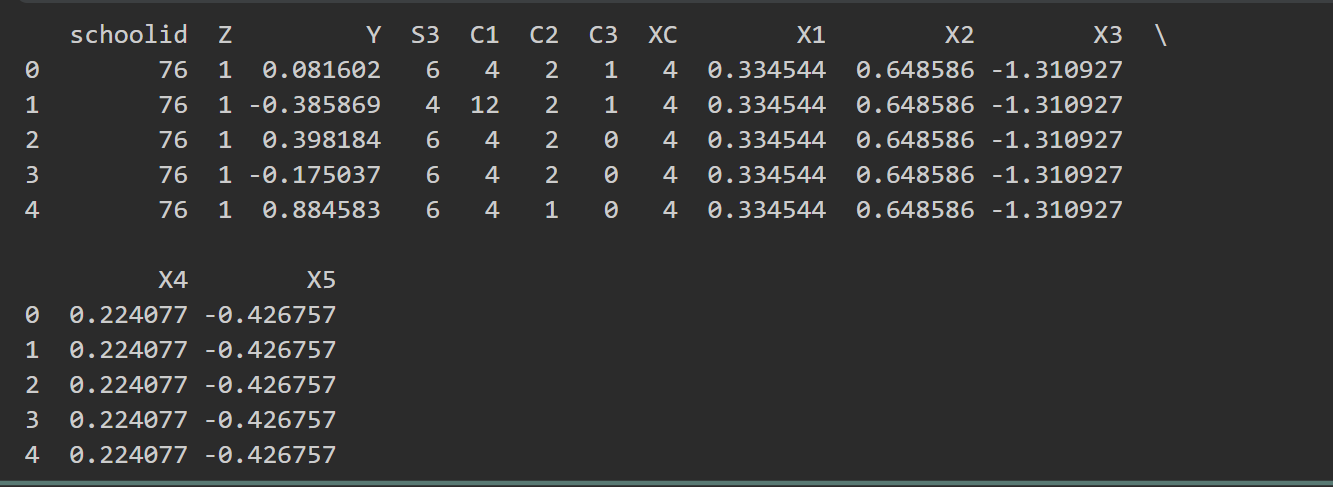

In [2]:
#To display the image
from IPython.display import Image
Image(filename='img.png')

In [3]:
# Columns are renamed to more descriptive names for clarity.
data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })


## Defining Covariates, Treatment, and Outcome Variables
Specifying which columns of the DataFrame represent the covariates, the treatment, and the outcome variables.
### Covariates
covariate_cols is a list of column names that represent the covariates in the analysis. Covariates (also known as features or independent variables) are variables that might influence the outcome variable.
Examples from the code:
        *   'S3': 'FutureSuccessExpectations',
        *   'C1': 'StudentRaceEthnicity',
        *   'C2': 'StudentGender',
        *   'C3': 'FirstGenCollegeStatus',
        *   'XC': 'SchoolUrbanicity',
        *   'X1': 'PreInterventionFixedMindset',
        *   'X2': 'SchoolAchievementLevel',
        *   'X3': 'SchoolMinorityComposition',
        *   'X4': 'PovertyConcentration',
        *   'X5': 'TotalStudentPopulation'
### Treatment
treatment_col specifies the column that represents the treatment variable. This variable indicates whether or not a the intervention or treatment was applied ( coded as 0 for no treatment and 1 for treatment).
Example in the code : the treatment column 'Z' GrowthMindsetIntervention.

### Outcome
outcome_col identifies the column that represents the outcome variable (or dependent variable), which is the variable we are trying to understand or predict, it is the variable of interest.


In [4]:
# Define covariates, treatment, and outcome
covariate_cols = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']
treatment_col = 'Z'
outcome_col = 'Y'

## Splitting the Data into a training set and testing set
The dataset has been divided into two subsets: a training set and a testing set.
The training set is used to train machine learning models, while the testing set is used to evaluate the model's performance on unseen data.

train_test_split() is a function from Scikit-Learn's model_selection module. It randomly splits the dataset into two parts:
Training set: Used to fit the model.
Testing set: Used to evaluate the model's performance.

test_size=0.3: This specifies that 30% of the data should be allocated to the testing set, and the remaining 70% should go to the training set.
random_state=42: This parameter controls the shuffling applied to the data before the split. Using a fixed random_state ensures that the split is reproducible, meaning you get the same training and testing sets every time you run the code.

In [5]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

## Standardizing the Covariates
The covariates (independent variables) are standardized to ensure that they are on a similar scale. Standardization is a preprocessing technique where each feature is transformed to have a mean of 0 and a standard deviation of 1. This is particularly important because covariates can vary widely in their ranges and units; some may span from 0 to 1000, while others might only vary between 0 and 1. If these variables are not standardized, those with larger ranges could disproportionately influence the model, leading to biased results.

To standardize the data, the code uses StandardScaler from Scikit-Learn’s preprocessing module. The scaler first calculates the mean and standard deviation of each covariate using the training data. It then applies these statistics to transform both the training and testing data. The training data is transformed using fit_transform, which both calculates the necessary statistics and applies the transformation. The testing data is transformed using transform, which ensures that the same scaling applied to the training data is also applied to the testing data, preserving consistency.

In [6]:
scaler = StandardScaler()

# Using .loc[] to ensure you're explicitly modifying the DataFrame
train_data.loc[:, covariate_cols] = scaler.fit_transform(train_data.loc[:, covariate_cols])
test_data.loc[:, covariate_cols] = scaler.transform(test_data.loc[:, covariate_cols])



C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


## Importing Modules
Several models are imported from Scikit-Learn’s library, including ensemble methods like RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, and AdaBoostRegressor. These models are known for their robustness and ability to capture complex relationships in data. Additionally, MLPRegressor (a neural network model), Ridge and Lasso (linear models with regularization), and SVR (Support Vector Regressor) are imported. Each of these models has a set of hyperparameters that can significantly impact their performance, and tuning these hyperparameters is critical to getting the best results.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

## Defining these parameter grids
The code then defines a dictionary, param_grids, where each key corresponds to a different model type (e.g., 'RandomForest', 'GradientBoosting', 'NeuralNetwork'). For each model, the dictionary contains two entries: 'model' specifies the model instance, and 'params' defines a grid of hyperparameters to search over.

## Models explained
For example, the RandomForestRegressor is associated with hyperparameters like n_estimators (number of trees in the forest), max_depth (maximum depth of the tree), and min_samples_split (minimum number of samples required to split an internal node). The values provided in the list under each hyperparameter will be tested in combination during the grid search process. Similarly, for GradientBoostingRegressor, the grid includes n_estimators, learning_rate (which controls the contribution of each tree to the final model), and max_depth.

MLPRegressor, a type of neural network, has hyperparameters such as hidden_layer_sizes, which controls the number and size of hidden layers, activation functions that determine the activation mechanism of neurons (e.g., ReLU, tanh), and solver methods for optimization (e.g., Adam, SGD)

The linear models Ridge and Lasso are tuned by adjusting the alpha parameter, which controls the strength of regularization. For SVR, key hyperparameters include kernel type (linear or RBF), C (regularization parameter), and epsilon (insensitivity parameter).

The ExtraTreesRegressor and AdaBoostRegressor models have similar hyperparameters to the other ensemble models, focusing on the number of estimators (n_estimators), depth of the trees (max_depth), and in the case of AdaBoost, the learning_rate.

In [8]:
# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 100)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.1, 0.2, 0.5]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

## Grid Search Cv
The function takes several inputs: the dataset (data), the column names for the treatment and outcome variables (treatment_col and outcome_col), a list of covariates (covariate_cols), the model to be tuned (model), a dictionary of hyperparameters to search over (params), and a string representing the meta-learner being used (meta_learner).

GridSearchCV is a powerful tool that automates the process of searching through a grid of hyperparameters to identify the optimal configuration. In this instance, the function specifies several important parameters: the estimator is set to the model passed to the function, and the param_grid contains the hyperparameters to be explored. The cv=5 parameter indicates that 5-fold cross-validation will be used, which involves splitting the data into five parts, training the model on four parts, and validating it on the remaining part, rotating this process until all data has been used for validation. This cross-validation approach helps ensure that the model’s performance is robust and not overly dependent on any particular subset of the data. The scoring parameter is set to neg_mean_squared_error, meaning that the model's performance is evaluated based on its Mean Squared Error, with a more negative value indicating better performance. The n_jobs=-1 parameter allows the computation to utilize all available CPU cores, speeding up the grid search process.
The function fits the model to the data using the fit(X, y) method, which trains the model across all combinations of the hyperparameters specified in the grid. Once the grid search is complete, the function prints out the best hyperparameters identified for the model and meta-learner combination, providing insight into which configuration yielded the best performance.

 Finally, the function returns the model trained with these optimal hyperparameters, which can then be used for making predictions or further analysis.

In [9]:
import numpy as np
def grid_search_cv(data, treatment_col, outcome_col, covariate_cols, model, params, meta_learner):
    """
    Perform GridSearchCV for hyperparameter tuning and return the best model.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)

    print(f'Best parameters for {meta_learner} with {model.__class__.__name__}: {grid_search.best_params_}')

    return grid_search.best_estimator_


## S-Learner
The function s_learner is designed to implement an S-Learner, which is a specific type of meta-learner used for estimating the Conditional Average Treatment Effect (CATE) in causal inference. The S-Learner is a straightforward method that combines both treatment and covariate information into a single machine learning model.

The s_learner function implements the S-Learner method, which is one of the simplest approaches to estimating the Conditional Average Treatment Effect (CATE). The S-Learner works by fitting a single model that includes both the treatment indicator and covariates. By training the model in this way, the S-Learner can estimate the effect of treatment by comparing the model's predictions under different treatment conditions. This method is straightforward and efficient, making it a popular choice in scenarios where the relationship between treatment, covariates, and the outcome can be captured effectively by a single model.


In [10]:
def s_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an S-learner model to estimate CATE.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]
    model.fit(X, y)
    return model

## T-Learner
The t_learner function is designed to implement a T-Learner, which is another meta-learning approach used in causal inference to estimate the Conditional Average Treatment Effect (CATE). The T-Learner differs from the S-Learner in that it trains separate models for the treated and control groups, allowing each group to have its own model that can capture potentially different relationships between covariates and outcomes.

The function begins by defining its input parameters:

data: This is the dataset containing all the relevant variables, typically structured as a Pandas DataFrame.

treatment_col: This parameter specifies the name of the column in the dataset that indicates whether an individual received the treatment (usually coded as 1) or not (coded as 0).

outcome_col: This parameter specifies the column name for the outcome variable, which is the target variable the models will aim to predict.

covariate_cols: This is a list of column names representing the covariates or independent variables that are considered in the analysis.

model: This represents the machine learning model that will be trained separately on the treated and control groups.

Inside the function, the dataset is first split into two subsets: one for the treated group and another for the control group. This is done by filtering the dataset based on the treatment_col. The treated group (treated) contains all rows where the treatment indicator is 1, and the control group (control) contains all rows where the treatment indicator is 0.

Next, the function extracts the covariate and outcome variables for both the treated and control groups. X_treated contains the covariate values for the treated group, and y_treated contains the corresponding outcome values. Similarly, X_control contains the covariate values for the control group, and y_control contains the corresponding outcome values.

The core of the T-Learner approach is then implemented by fitting separate models for the treated and control groups. The function uses the provided model to fit X_treated to y_treated, resulting in model_treated, which is trained on the treated group data. Similarly, model_control is trained by fitting X_control to y_control, which captures the relationship between the covariates and outcomes for the control group.

Finally, the function returns the two trained models, model_treated and model_control. These models can be used to estimate the CATE by predicting the outcomes for a given set of covariates under both treatment and control conditions. The difference between these two predictions provides an estimate of the CATE for those covariates.

In [11]:
def t_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train a T-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    return model_treated, model_control

## X-Learner
The x_learner function is designed to implement an X-Learner, which is a more advanced meta-learning approach used in causal inference to estimate the Conditional Average Treatment Effect (CATE). The X-Learner builds upon the T-Learner by incorporating an additional step where it leverages information from both treated and control groups to improve the estimation of treatment effects. This method is particularly useful in situations where there is an imbalance between the treatment and control groups or when the treatment effect varies across different subpopulations.

The function starts by splitting the dataset into treated and control groups based on the treatment_col. Specifically, the treated group (treated) contains all observations where the treatment indicator is 1, and the control group (control) contains observations where the treatment indicator is 0. This is similar to what is done in the T-Learner approach.

Next, the function extracts the covariate and outcome variables for both the treated and control groups. X_treated and y_treated represent the covariates and outcomes for the treated group, respectively, while X_control and y_control represent the covariates and outcomes for the control group.

The function then fits separate models to the treated and control groups using the provided machine learning model. model_treated is trained on the treated group's data (X_treated and y_treated), and model_control is trained on the control group's data (X_control and y_control). These models capture the relationship between covariates and outcomes within each group.

What sets the X-Learner apart from the T-Learner is the additional step where the outcomes of the treated group are predicted using the control group model (model_control), and the outcomes of the control group are predicted using the treated group model (model_treated). These predicted outcomes represent the counterfactual outcomes—what the treated group's outcomes would have been had they not been treated, and vice versa.

The function then calculates the treatment effects for the treated and control groups by taking the difference between the actual outcomes and the predicted counterfactual outcomes. Specifically:

treatment_effect_treated is calculated as the difference between the actual outcomes (y_treated) of the treated group and the outcomes predicted by the control group model (treated_outcome).

treatment_effect_control is calculated as the difference between the outcomes predicted by the treated group model (control_outcome) and the actual outcomes (y_control) of the control group.

In the final step, these calculated treatment effects are used as new target variables, and separate models are trained again on the treated and control groups. model_treatment_effect_treated is trained on the treated group’s covariates (X_treated) to predict the treatment effect for this group, while model_treatment_effect_control is trained on the control group’s covariates (X_control) to predict the treatment effect for the control group. The function returns these two models.

t_residual_clipped: Ensures that the residuals for treatment assignment are not too small, which could destabilize the model. Clipping them to a minimum value (0.01) prevents division by zero in the later steps.

Both y_residual and t_residual_clipped are standardized by subtracting their mean and dividing by their standard deviation. This normalization ensures that the residuals are on a comparable scale, which is important for the subsequent modeling step.

In [12]:
def x_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an X-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    treated_outcome = model_control.predict(X_treated)
    control_outcome = model_treated.predict(X_control)
    treatment_effect_treated = y_treated - treated_outcome
    treatment_effect_control = control_outcome - y_control
    model_treatment_effect_treated = model.fit(X_treated, treatment_effect_treated)
    model_treatment_effect_control = model.fit(X_control, treatment_effect_control)
    return model_treatment_effect_treated, model_treatment_effect_control

## R-Learner
The R-Learner is a more advanced and flexible meta-learning approach that builds on ideas from double/debiased machine learning. It works by first modeling the outcome and treatment assignment separately, then using the residuals from these models to estimate the treatment effect. This method is particularly effective in reducing bias due to confounding variables.

Input Parameters:

data: This is the dataset containing all relevant variables, typically organized as a Pandas DataFrame.

treatment_col: The name of the column in the dataset indicating treatment assignment (often binary, where 1 indicates treatment and 0 indicates control).

outcome_col: The name of the column representing the outcome variable, which is the target variable the model aims to predict.

covariate_cols: A list of column names representing the covariates or independent variables that might affect both treatment assignment and outcome.

model: The machine learning model that will be used to fit the data. This could be any regression model, such as linear regression, ridge regression, or more complex models.

The function begins by extracting the covariates (X), treatment assignment (T), and outcome (y) from the dataset.Two separate models are trained:

y_model: This model is trained to predict the outcome variable y using the covariates X.
t_model: This model is trained to predict the treatment assignment T using the same covariates X.
These models help to understand how covariates influence both the outcome and treatment assignment.Residuals represent the difference between the actual values and the predicted values:

y_residual: The residuals from the outcome model, representing the portion of the outcome that is not explained by the covariates.
t_residual: The residuals from the treatment model, representing the portion of the treatment assignment not explained by the covariates.

In [13]:
def r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an R-learner model to estimate CATE.
    """
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]
    y_model = model
    y_model.fit(X, y)
    t_model = model
    t_model.fit(X, T)
    y_residual = y - y_model.predict(X)
    t_residual = T - t_model.predict(X)
    t_residual_clipped = t_residual.clip(lower=0.01)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual + epsilon
    tau_model = Ridge(alpha=1.0)
    tau_model.fit(X, y_residual / t_residual_regularized)
    return tau_model, y_model, t_model, y_residual, t_residual

## Evaluate the Performance of meta-Learners for Estimating CATE
To evaluate the performance of different meta-learners (S-Learner, T-Learner, X-Learner, and R-Learner) in estimating the Conditional Average Treatment Effect (CATE) it is training models ng various machine learning algrithms, the accessing their performance on atest dataset using Mean Square Error(MSE) as the evalutaion metric.

MSE measures the average squared difference between the observed actual outcomes and the outcomes predicted by the model.
The evaluate_model function is designed to predict outcomes on a test dataset using a given model and meta-learner approach, and then evaluate the model's performance using MSE.
Function extracts the covariates and treatment column (X_test) as well as the outcome column (y_test) from the test dataset. X_test includes all the features (covariates) plus the treatment indicator, which is to be used for generating predictions.

### Model Prediction Based on Meta-Learner Type
The function then makes predictions based on the type of meta-learner specified:

For the S-Learner, a single model is used to predict outcomes for the test data. The model is applied directly to X_test, which includes both the covariates and the treatment indicator.

For the T-Learner and X-Learner, two separate models are used: one for the treated group and one for the control group. The function first predicts the outcomes for the treated group using the treated model and for the control group using the control model. These predictions are then combined into a single series of predictions.

For the R-Learner, the function uses the tau_model to predict the treatment effects directly based on the covariates in test_data.

After generating the predictions, the function calculates the MSE by comparing the predicted outcomes to the actual outcomes (y_test). The MSE is returned as the measure of the model’s performance.

### Evaluation
The performance of various meta-learners has been evaluated using different machine learning models, performing hyperparameter tuning using GridSearchCV, training the models, and evaluating them on the test dataset.

* Each model defined in param_grids undergoes hyperparameter tuning with grid_search_cv.
* The best model from this tuning process is used to train an S-Learner, T-Learner, X-Learner, or R-Learner.
* The evaluate_model function is then called to compute the MSE for each meta-learner and model combination.
* The results (meta-learner type, model name, and corresponding MSE) are stored in mse_results.

### Summarizing Results
Finally, the results are compiled into a DataFrame which provides a summary of the MSE for each meta-learner and machine learning model combination, allowing for easy comparison of their performance.


In [14]:
from sklearn.metrics import mean_squared_error

def evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, model, meta_learner):
    X_test = test_data[covariate_cols + [treatment_col]]
    y_test = test_data[outcome_col]
    if meta_learner == 's':
        predictions = model.predict(X_test)
    elif meta_learner == 't':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'x':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'r':
        tau_model, _, _, _, _ = model
        predictions = tau_model.predict(test_data[covariate_cols])
        print("Predictions:")
        print(pd.Series(predictions).describe())
    mse = mean_squared_error(y_test, predictions)
    return mse

mse_results = []

for model_name, config in param_grids.items():
    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'S-Learner')
    s_model = s_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    mse_s = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, s_model, 's')
    mse_results.append({'Meta-Learner': 'S-Learner', 'Model': model_name, 'MSE': mse_s})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'T-Learner')
    t_model_treated, t_model_control = t_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    mse_t = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (t_model_treated, t_model_control), 't')
    mse_results.append({'Meta-Learner': 'T-Learner', 'Model': model_name, 'MSE': mse_t})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'X-Learner')
    x_model_treated, x_model_control = x_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    mse_x = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (x_model_treated, x_model_control), 'x')
    mse_results.append({'Meta-Learner': 'X-Learner', 'Model': model_name, 'MSE': mse_x})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'R-Learner')
    r_model, y_model, t_model, y_residual, t_residual = r_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    mse_r = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (r_model, y_model, t_model, y_residual, t_residual), 'r')
    mse_results.append({'Meta-Learner': 'R-Learner', 'Model': model_name, 'MSE': mse_r})

mse_df = pd.DataFrame(mse_results)

Best parameters for S-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for T-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for X-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for R-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Predictions:
count    3118.000000
mean        0.447656
std         0.844830
min        -1.639598
25%        -0.113575
50%         0.390171
75%         0.911204
max         3.862713
dtype: float64
Best parameters for S-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for T-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for X-Learner with GradientBoostingRegressor: {'learning

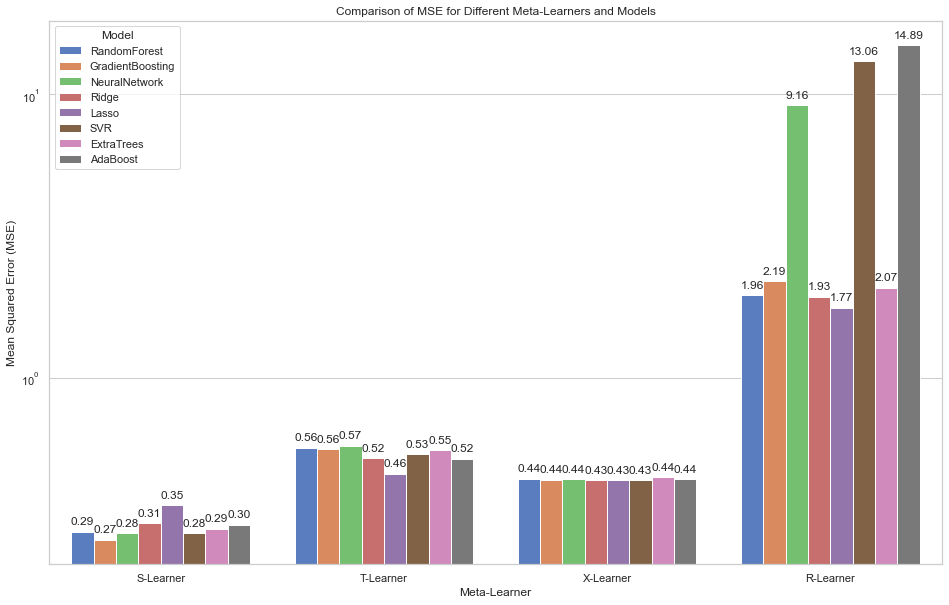

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="whitegrid")

# plt.figure(figsize=(16, 10))
# sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df, palette="muted")
# plt.title('Comparison of MSE for Different Meta-Learners and Models')
# plt.xlabel('Meta-Learner')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.legend(title='Model')
# plt.yscale('log')
# plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(16, 10))
ax = sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df, palette="muted")
plt.title('Comparison of MSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Model')
plt.yscale('log')

# Adding the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()


## Modify the Evaluation Function to Use EMSE
creating a new function evaluate_emse that will approximate EMSE using bootstrapping.


In [16]:
from sklearn.utils import resample

def evaluate_emse(data, treatment_col, outcome_col, covariate_cols, model, meta_learner, n_bootstraps=100, n_splits=5):
    """
    Evaluate the model using bootstrapping to approximate the EMSE.
    
    n_bootstraps: Number of bootstrap samples to generate
    n_splits: Number of folds in cross-validation (for the inner MSE calculation)
    """
    mse_list = []
    
    for _ in range(n_bootstraps):
        # Create a bootstrapped sample
        bootstrapped_data = resample(data, replace=True)
        
        # Evaluate the model using cross-validation on the bootstrapped sample
        X = bootstrapped_data[covariate_cols + [treatment_col]]
        y = bootstrapped_data[outcome_col]
        
        if meta_learner == 's':
            predictions = model.predict(X)
        elif meta_learner == 't':
            treated, control = model
            predictions_treated = treated.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 1][covariate_cols])
            predictions_control = control.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 0][covariate_cols])
            predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
        elif meta_learner == 'x':
            treated, control = model
            predictions_treated = treated.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 1][covariate_cols])
            predictions_control = control.predict(bootstrapped_data[bootstrapped_data[treatment_col] == 0][covariate_cols])
            predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
        elif meta_learner == 'r':
            tau_model, _, _, _, _ = model
            predictions = tau_model.predict(bootstrapped_data[covariate_cols])
        
        mse = mean_squared_error(y, predictions)
        mse_list.append(mse)
    
    # Calculate the EMSE as the mean of the MSEs from the bootstrapped samples
    emse = np.mean(mse_list)
    return emse


## 1. Enhanced R-Learner Implementation with Additional Regularization and Model Tuning
To enhance the R-Learner performance by introducing more flexible models for the residuals and experimenting with different regularization techniques and modifying the r_learner function


In [17]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def enhanced_r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an improved R-learner model to estimate CATE with robust residual handling and regularization.
    
    Parameters:
    - data: DataFrame containing the data
    - treatment_col: Column name for the treatment variable
    - outcome_col: Column name for the outcome variable
    - covariate_cols: List of column names for covariates
    - model: The base model to be used for predicting outcomes and treatment
    - regularization: Type of regularization to use ('ridge' or 'lasso')
    
    Returns:
    - tau_model: The trained model for estimating treatment effects
    - y_model: The outcome model
    - t_model: The treatment model
    - y_residual: Residuals of the outcome model
    - t_residual: Residuals of the treatment model
    """
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]

    # Fit outcome model
    y_model = cross_val_predict(model, X, y, cv=5)
    
    # Fit treatment model
    t_model = cross_val_predict(model, X, T, cv=5)
    
    # Calculate residuals
    y_residual = y - y_model
    t_residual = T - t_model
    
    # Regularization of residuals
    t_residual_clipped = np.clip(t_residual, a_min=0.01, a_max=None)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)
    
    # Add a small constant to prevent division by zero
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual_clipped + epsilon
    
#     # Use RidgeCV or LassoCV for additional regularization in the final model
#     regularization = 'ridge'
#     tau_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    regularization = 'lasso'
    tau_model = LassoCV(alphas=[0.1, 1.0, 10.0])
    
    
    # Fit the treatment effect model
    tau_model.fit(X, y_residual / t_residual_regularized)
    
    return tau_model, y_model, t_model, y_residual, t_residual


## Runing EMSE Evaluation for All Meta-Learners
evaluate_emse function to evaluate all meta-learners using EMSE.

In [ ]:
emse_results = []

for model_name, config in param_grids.items():
    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'S-Learner')
    s_model = s_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_s = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, s_model, 's')
    emse_results.append({'Meta-Learner': 'S-Learner', 'Model': model_name, 'EMSE': emse_s})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'T-Learner')
    t_model_treated, t_model_control = t_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_t = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (t_model_treated, t_model_control), 't')
    emse_results.append({'Meta-Learner': 'T-Learner', 'Model': model_name, 'EMSE': emse_t})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'X-Learner')
    x_model_treated, x_model_control = x_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_x = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (x_model_treated, x_model_control), 'x')
    emse_results.append({'Meta-Learner': 'X-Learner', 'Model': model_name, 'EMSE': emse_x})

    best_model = grid_search_cv(train_data, treatment_col, outcome_col, covariate_cols, config['model'], config['params'], 'R-Learner')
    r_model, y_model, t_model, y_residual, t_residual = enhanced_r_learner(train_data, treatment_col, outcome_col, covariate_cols, best_model)
    emse_r = evaluate_emse(test_data, treatment_col, outcome_col, covariate_cols, (r_model, y_model, t_model, y_residual, t_residual), 'r')
    emse_results.append({'Meta-Learner': 'Enhanced R-Learner', 'Model': model_name, 'EMSE': emse_r})

emse_df = pd.DataFrame(emse_results)


Best parameters for S-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for T-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for X-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for R-Learner with RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for S-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for T-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for X-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for R-Learner with GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best parameters for S-Le

## Plot the EMSE Results


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(16, 10))
ax = sns.barplot(x='Meta-Learner', y='EMSE', hue='Model', data=emse_df, palette="muted")
plt.title('Comparison of EMSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Expected Mean Squared Error (EMSE)')
plt.legend(title='Model')
plt.yscale('log')

# Adding the numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()
plt.savefig("Model_Evaluation_using_GridSearch.png", dpi=300)
